In [31]:
import json
from tqdm import tqdm
import pandas as pd
from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import random

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
def get_metadata():
    with open("../input/arxiv/arxiv-metadata-oai-snapshot.json") as f:
        for line in f:
            yield line

In [4]:
metadata = get_metadata()

for paper in metadata:
    first_paper = json.loads(paper)
    break
    
for key in first_paper:
    print(key, ':', first_paper[key])

id : 0704.0001
submitter : Pavel Nadolsky
authors : C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title : Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments : 37 pages, 15 figures; published version
journal-ref : Phys.Rev.D76:013009,2007
doi : 10.1103/PhysRevD.76.013009
report-no : ANL-HEP-PR-07-12
categories : hep-ph
license : None
abstract :   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detai

In [5]:
author = [] 
title = []
categories = []
abstract = []

n_journal_publicated = 0

for ind, paper in tqdm(enumerate(metadata)):
    paper = json.loads(paper)
    if paper['journal-ref'] != None:
        n_journal_publicated += 1      
        author.append(paper['submitter'])
        title.append(paper['title'])
        categories.append(paper['categories'])
        abstract.append(paper['abstract'])

print(f'paper publicated on journals is: {n_journal_publicated}')

2061366it [01:02, 32997.79it/s]

paper publicated on journals is: 761112


In [6]:
df = pd.DataFrame({'author':author,
                   'title':title,
                   'categories':categories, 
                   'abstract':abstract})
df.head()

,author,title,categories,abstract
0,Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...
1,Alejandro Corichi,Polymer Quantum Mechanics and its Continuum Limit,gr-qc,A rather non-standard quantum representation...
2,Damian Swift,Numerical solution of shock and ramp compressi...,cond-mat.mtrl-sci,A general formulation was developed to repre...
3,Paul Harvey,"The Spitzer c2d Survey of Large, Nearby, Inste...",astro-ph,We discuss the results from the combined IRA...
4,Christian Stahn,Fermionic superstring loop amplitudes in the p...,hep-th,The pure spinor formulation of the ten-dimen...


In [7]:
df.shape

(761112, 4)

In [8]:
papers = pd.DataFrame({
    'title': title,
    'abstract': abstract,
    'categories': categories
})

papers = papers.iloc[:20000]

papers['abstract'] = papers['abstract'].apply(lambda x: x.replace("\n",""))
papers['abstract'] = papers['abstract'].apply(lambda x: x.strip())
papers['text'] = papers['title'] + '. ' + papers['abstract']

papers['categories'] = papers['categories'].apply(lambda x: tuple(x.split()))

shortlisted_categories = papers['categories'].value_counts().reset_index(name="count").query("count > 250")["index"].tolist()
papers = papers[papers["categories"].isin(shortlisted_categories)].reset_index(drop=True)

papers = papers.sample(frac=1).reset_index(drop=True)

papers = papers.groupby('categories').head(250).reset_index(drop=True)

multi_label_encoder = MultiLabelBinarizer()
multi_label_encoder.fit(papers['categories'])
papers['categories_encoded'] = papers['categories'].apply(lambda x: multi_label_encoder.transform([x])[0])

papers = papers[["text", "categories", "categories_encoded"]]
papers.head()

,text,categories,categories_encoded
0,Bubbling Calabi-Yau geometry from matrix model...,"(hep-th,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,The Stueckelberg Extension and Milli Weak and ...,"(hep-ph,)","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,Electric dipole-forbidden nuclear transitions ...,"(nucl-th,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,Detection of Atmospheric Muon Neutrinos with t...,"(astro-ph,)","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Lattice Calculation of Thermal Properties of L...,"(nucl-th,)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [9]:
papers.shape

(3000, 3)

In [10]:
train, test = train_test_split(papers, test_size=0.3, stratify=papers['categories'], random_state=42)

Модель:

In [11]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 4,
    "num_train_epochs": 4,
}

model = MultiLabelClassificationModel('bert', 
                                      'bert-base-cased', 
                                      num_labels=len(shortlisted_categories), 
                                      args=model_args)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [14]:
model.train_model(train[['text', 'categories_encoded']])

  0%|          | 0/2100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/525 [00:00<?, ?it/s]

(2100, 0.10564056748258216)

In [17]:
result, model_outputs, wrong_predictions = model.eval_model(test[['text', 'categories_encoded']])
print(result)

  0%|          | 0/900 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

{'LRAP': 0.9010626903960242, 'eval_loss': 0.08507322279357277}


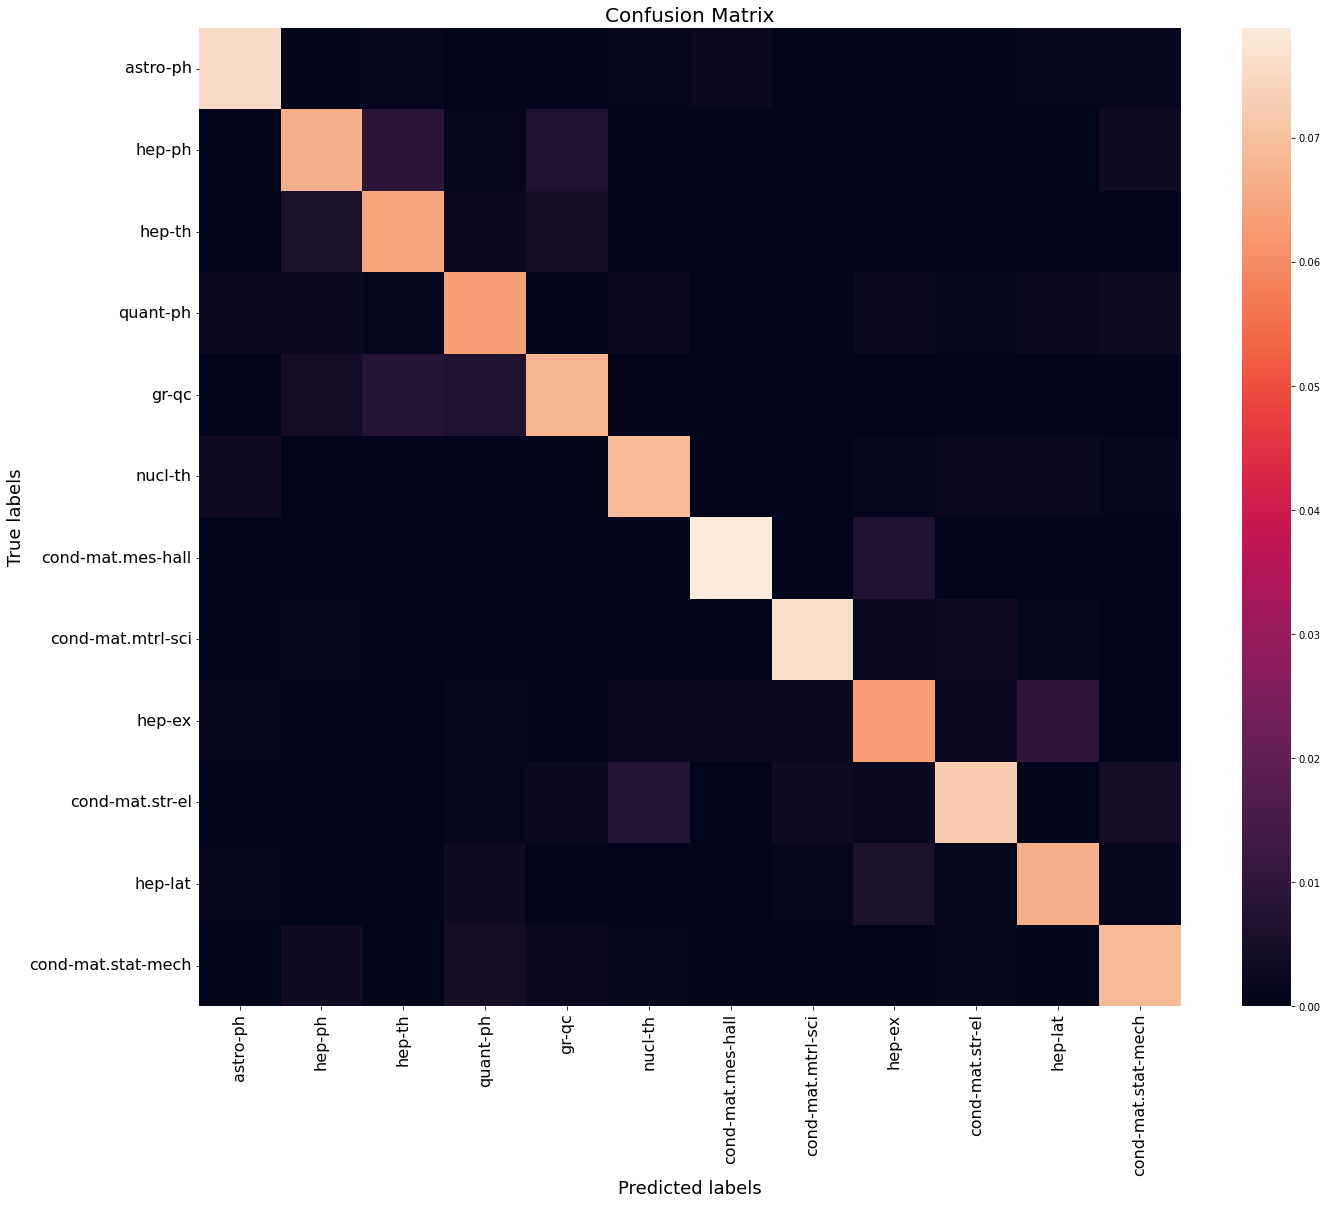

In [29]:
predicted_categories_argmax = list(map(lambda x: np.argmax(x), model_outputs))
predicted_categories_encoded = np.eye(len(shortlisted_categories))[predicted_categories_argmax]
predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)

eval_gt_labels = test["categories"].tolist()

shortlisted_categories_formatted = list(map(lambda x: list(x)[0], shortlisted_categories))

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_categories, eval_gt_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix))
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(shortlisted_categories_formatted, rotation=90, fontsize=16)
ax.set_yticklabels(shortlisted_categories_formatted, rotation=0, fontsize=16)

plt.show()

In [34]:
category_map = {'astro-ph': 'Astrophysics',
                'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
                'astro-ph.EP': 'Earth and Planetary Astrophysics',
                'astro-ph.GA': 'Astrophysics of Galaxies',
                'astro-ph.HE': 'High Energy Astrophysical Phenomena',
                'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
                'astro-ph.SR': 'Solar and Stellar Astrophysics',
                'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
                'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
                'cond-mat.mtrl-sci': 'Materials Science',
                'cond-mat.other': 'Other Condensed Matter',
                'cond-mat.quant-gas': 'Quantum Gases',
                'cond-mat.soft': 'Soft Condensed Matter',
                'cond-mat.stat-mech': 'Statistical Mechanics',
                'cond-mat.str-el': 'Strongly Correlated Electrons',
                'cond-mat.supr-con': 'Superconductivity',
                'cs.AI': 'Artificial Intelligence',
                'cs.AR': 'Hardware Architecture',
                'cs.CC': 'Computational Complexity',
                'cs.CE': 'Computational Engineering, Finance, and Science',
                'cs.CG': 'Computational Geometry',
                'cs.CL': 'Computation and Language',
                'cs.CR': 'Cryptography and Security',
                'cs.CV': 'Computer Vision and Pattern Recognition',
                'cs.CY': 'Computers and Society',
                'cs.DB': 'Databases',
                'cs.DC': 'Distributed, Parallel, and Cluster Computing',
                'cs.DL': 'Digital Libraries',
                'cs.DM': 'Discrete Mathematics',
                'cs.DS': 'Data Structures and Algorithms',
                'cs.ET': 'Emerging Technologies',
                'cs.FL': 'Formal Languages and Automata Theory',
                'cs.GL': 'General Literature',
                'cs.GR': 'Graphics',
                'cs.GT': 'Computer Science and Game Theory',
                'cs.HC': 'Human-Computer Interaction',
                'cs.IR': 'Information Retrieval',
                'cs.IT': 'Information Theory',
                'cs.LG': 'Machine Learning',
                'cs.LO': 'Logic in Computer Science',
                'cs.MA': 'Multiagent Systems',
                'cs.MM': 'Multimedia',
                'cs.MS': 'Mathematical Software',
                'cs.NA': 'Numerical Analysis',
                'cs.NE': 'Neural and Evolutionary Computing',
                'cs.NI': 'Networking and Internet Architecture',
                'cs.OH': 'Other Computer Science',
                'cs.OS': 'Operating Systems',
                'cs.PF': 'Performance',
                'cs.PL': 'Programming Languages',
                'cs.RO': 'Robotics',
                'cs.SC': 'Symbolic Computation',
                'cs.SD': 'Sound',
                'cs.SE': 'Software Engineering',
                'cs.SI': 'Social and Information Networks',
                'cs.SY': 'Systems and Control',
                'econ.EM': 'Econometrics',
                'eess.AS': 'Audio and Speech Processing',
                'eess.IV': 'Image and Video Processing',
                'eess.SP': 'Signal Processing',
                'gr-qc': 'General Relativity and Quantum Cosmology',
                'hep-ex': 'High Energy Physics - Experiment',
                'hep-lat': 'High Energy Physics - Lattice',
                'hep-ph': 'High Energy Physics - Phenomenology',
                'hep-th': 'High Energy Physics - Theory',
                'math.AC': 'Commutative Algebra',
                'math.AG': 'Algebraic Geometry',
                'math.AP': 'Analysis of PDEs',
                'math.AT': 'Algebraic Topology',
                'math.CA': 'Classical Analysis and ODEs',
                'math.CO': 'Combinatorics',
                'math.CT': 'Category Theory',
                'math.CV': 'Complex Variables',
                'math.DG': 'Differential Geometry',
                'math.DS': 'Dynamical Systems',
                'math.FA': 'Functional Analysis',
                'math.GM': 'General Mathematics',
                'math.GN': 'General Topology',
                'math.GR': 'Group Theory',
                'math.GT': 'Geometric Topology',
                'math.HO': 'History and Overview',
                'math.IT': 'Information Theory',
                'math.KT': 'K-Theory and Homology',
                'math.LO': 'Logic',
                'math.MG': 'Metric Geometry',
                'math.MP': 'Mathematical Physics',
                'math.NA': 'Numerical Analysis',
                'math.NT': 'Number Theory',
                'math.OA': 'Operator Algebras',
                'math.OC': 'Optimization and Control',
                'math.PR': 'Probability',
                'math.QA': 'Quantum Algebra',
                'math.RA': 'Rings and Algebras',
                'math.RT': 'Representation Theory',
                'math.SG': 'Symplectic Geometry',
                'math.SP': 'Spectral Theory',
                'math.ST': 'Statistics Theory',
                'math-ph': 'Mathematical Physics',
                'nlin.AO': 'Adaptation and Self-Organizing Systems',
                'nlin.CD': 'Chaotic Dynamics',
                'nlin.CG': 'Cellular Automata and Lattice Gases',
                'nlin.PS': 'Pattern Formation and Solitons',
                'nlin.SI': 'Exactly Solvable and Integrable Systems',
                'nucl-ex': 'Nuclear Experiment',
                'nucl-th': 'Nuclear Theory',
                'physics.acc-ph': 'Accelerator Physics',
                'physics.ao-ph': 'Atmospheric and Oceanic Physics',
                'physics.app-ph': 'Applied Physics',
                'physics.atm-clus': 'Atomic and Molecular Clusters',
                'physics.atom-ph': 'Atomic Physics',
                'physics.bio-ph': 'Biological Physics',
                'physics.chem-ph': 'Chemical Physics',
                'physics.class-ph': 'Classical Physics',
                'physics.comp-ph': 'Computational Physics',
                'physics.data-an': 'Data Analysis, Statistics and Probability',
                'physics.ed-ph': 'Physics Education',
                'physics.flu-dyn': 'Fluid Dynamics',
                'physics.gen-ph': 'General Physics',
                'physics.geo-ph': 'Geophysics',
                'physics.hist-ph': 'History and Philosophy of Physics',
                'physics.ins-det': 'Instrumentation and Detectors',
                'physics.med-ph': 'Medical Physics',
                'physics.optics': 'Optics',
                'physics.plasm-ph': 'Plasma Physics',
                'physics.pop-ph': 'Popular Physics',
                'physics.soc-ph': 'Physics and Society',
                'physics.space-ph': 'Space Physics',
                'q-bio.BM': 'Biomolecules',
                'q-bio.CB': 'Cell Behavior',
                'q-bio.GN': 'Genomics',
                'q-bio.MN': 'Molecular Networks',
                'q-bio.NC': 'Neurons and Cognition',
                'q-bio.OT': 'Other Quantitative Biology',
                'q-bio.PE': 'Populations and Evolution',
                'q-bio.QM': 'Quantitative Methods',
                'q-bio.SC': 'Subcellular Processes',
                'q-bio.TO': 'Tissues and Organs',
                'q-fin.CP': 'Computational Finance',
                'q-fin.EC': 'Economics',
                'q-fin.GN': 'General Finance',
                'q-fin.MF': 'Mathematical Finance',
                'q-fin.PM': 'Portfolio Management',
                'q-fin.PR': 'Pricing of Securities',
                'q-fin.RM': 'Risk Management',
                'q-fin.ST': 'Statistical Finance',
                'q-fin.TR': 'Trading and Market Microstructure',
                'quant-ph': 'Quantum Physics',
                'stat.AP': 'Applications',
                'stat.CO': 'Computation',
                'stat.ME': 'Methodology',
                'stat.ML': 'Machine Learning',
                'stat.OT': 'Other Statistics',
                'stat.TH': 'Statistics Theory'}

In [37]:
for _ in range(5):

    random_idx = random.randint(0, len(test)-1)
    text = test.iloc[random_idx]['text']
    true_categories = test.iloc[random_idx]['categories']

    predicted_categories_encoded, raw_outputs = model.predict([text])
    predicted_categories_encoded = np.array(predicted_categories_encoded)
    predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
    predicted_categories = multi_label_encoder.inverse_transform(predicted_categories_encoded)[0]

    print(f'True Categories:'.ljust(21,' '), f'{true_categories} - {category_map[true_categories[0]]}\n')
    print(f'Predicted Categories: {predicted_categories} - {category_map[predicted_categories[0]]}\n')
    print(f'Abstract: {text}\n\n')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('hep-lat',) - High Energy Physics - Lattice

Predicted Categories: ('hep-lat',) - High Energy Physics - Lattice

Abstract: Diquark Representations for Singly Heavy Baryons with Light Staggered
  Quarks. In the staggered fermion formulation of lattice QCD, we construct diquarkoperators which are to be embedded in singly heavy baryons. The grouptheoretical connections between continuum and lattice staggered diquarkrepresentations are established.




  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('hep-ph',) - High Energy Physics - Phenomenology

Predicted Categories: ('hep-ph',) - High Energy Physics - Phenomenology

Abstract: The Landscape of Sparticle Mass Hierarchies and Their Signature Space at
  the LHC. The minimal supersymmetric standard model with soft breaking has a largelandscape of supersymmetric particle mass hierarchies. This number is reducedsignificantly in well-motivated scenarios such as minimal supergravity andalternatives. We carry out an analysis of the landscape for the first fourlightest particles and identify at least 16 mass patterns, and providebenchmarks for each. We study the signature space for the patterns at the CERNLarge Hadron Collider by analyzing the lepton + (jet $\geq 2$) + missing $P_T$signals with 0, 1, 2 and 3 leptons. Correlations in missing $P_T$ are alsoanalyzed. It is found that even with 10 fb$^{-1}$ of data a significantdiscrimination among patterns emerges




  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('hep-ph',) - High Energy Physics - Phenomenology

Predicted Categories: ('hep-ph',) - High Energy Physics - Phenomenology

Abstract: Two-loop SUSY QCD corrections to the chargino masses in the MSSM. We have calculated the two-loop strong interaction corrections to thechargino pole masses in the DRbar'-scheme in the Minimal SupersymmetricStandard Model (MSSM) with complex parameters. We have performed a detailednumerical analysis for a particular point in the parameter space and foundcorrections of a few tenths of a percent. We provide a computer program whichcalculates chargino and neutralino masses with complex parameters including theone-loop corrections and all two-loop SQCD effects.




  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('cond-mat.stat-mech',) - Statistical Mechanics

Predicted Categories: ('cond-mat.stat-mech',) - Statistical Mechanics

Abstract: Heat and Fluctuations from Order to Chaos. The Heat theorem reveals the second law of equilibrium Thermodynamics(i.e.existence of Entropy) as a manifestation of a general property ofHamiltonian Mechanics and of the Ergodic Hypothesis, valid for 1 as well as$10^{23}$ degrees of freedom systems, {\it i.e.} for simple as well as verycomplex systems, and reflecting the Hamiltonian nature of the microscopicmotion. In Nonequilibrium Thermodynamics theorems of comparable generality donot seem to be available. Yet it is possible to find general, modelindependent, properties valid even for simple chaotic systems ({\it i.e.} thehyperbolic ones), which acquire special interest for large systems: the ChaoticHypothesis leads to the Fluctuation Theorem which provides general propertiesof certain very large fluctuations and reflects the time-reversal 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

True Categories:      ('hep-ex',) - High Energy Physics - Experiment

Predicted Categories: ('hep-ex',) - High Energy Physics - Experiment

Abstract: Study of B0 -> pi0 pi0, B -> pi pi0, and B -> K pi0 Decays, and Isospin
  Analysis of B -> pipi Decays. We present updated measurements of the branching fractions and CP asymmetriesfor B0 -> pi0 pi0, B+ -> pi+ pi0, and B+ -> K+ pi0. Based on a sample of 383 x10^6 Upsilon(4S) -> B Bbar decays collected by the BABAR detector at the PEP-IIasymmetric-energy B factory at SLAC, we measure B(B0 -> pi0 pi0) =(1.47 +/-0.25 +/- 0.12) x 10^-6, B(B+ -> pi+ pi0)= (5.02 +/- 0.46 +/- 0.29) x 10^-6, andB(B+ -> K+ pi0) = (13.6 +/- 0.6 +/- 0.7) x 10^-6. We also measure the CPasymmetries C(pi0 pi0) = -0.49 +/- 0.35 +/- 0.05, A(pi+ pi0) = 0.03 +/- 0.08+/- 0.01, and A(K+ pi0) = 0.030 +/- 0.039 +/- 0.010. Finally, we present boundson the CKM angle $\alpha$ using isospin relations.


